In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt

In [2]:
import matplotlib.pyplot as pl
%matplotlib inline

In [3]:
dfn = pd.read_pickle('../pickleJar/df_normalized.pkl')
df = pd.read_pickle('../pickleJar/df.pkl')

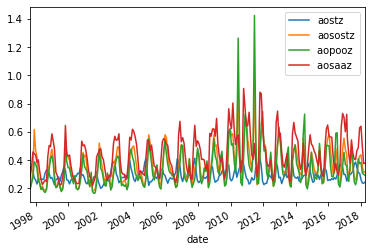

In [4]:
df.filter(regex='^ao', axis=1).plot();

In [5]:
dfn.index[0]

Timestamp('1997-09-01 00:00:00')

In [6]:
def dates_to_idx(timelist):
    reference_time = timelist[0]
    t = (timelist - reference_time) / pd.Timedelta(1, "Y")
    return np.asarray(t)

In [7]:
dfaosaaz = df.loc[:, ['aosaaz ']].merge(dfn.aosaaz_n,
                                        left_index=True, right_index=True)

In [8]:
dfaosaaz.rename(columns={k:v for k,v in zip(dfaosaaz.columns, ['y', 'yn'])}, 
                 inplace=True)

In [9]:
t = dates_to_idx(dfn.index)

In [10]:
dfaosaaz.insert(1, 't', t)

In [11]:
dfaosaaz.head()

,y,t,yn
date,,,
1997-09-01,0.28457,0.000000,0.000000
1997-10-01,0.35077,0.082137,0.468857
1997-11-01,0.45735,0.167012,1.223702
1997-12-01,0.44453,0.249150,1.132906
1998-01-01,0.43567,0.334025,1.070155


In [12]:
df_aosaaz_early = dfaosaaz.loc[:'2017-12-01']
df_aosaaz_late = dfaosaaz.loc['2018':]

### Modeling AOSAAZ chlorophyll time series using GPs

As a starting point, we use the GP model described in Rasmussen & Williams. Instead of using flat priors on covariance function hyperparameters and then maximizing the marginal likelihood like is done in the textbook, we place somewhat informative priors on the hyperparameters and use optimization to find the MAP point. We use the gp.Marginal since Gaussian noise is assumed.
The R+W model is a sum of three GPs for the signal, and one GP for the noise.

1. A long term smooth rising trend represented by an exponentiated quadratic kernel.
2. periodic term that decays away from exact periodicity. This is represented by the product of a Periodic covariance function and an exponentiated quadratic.
3. Small and medium term irregularities with a rational quadratic kernel.
4. The noise is modeled as the sum of an Exponential and a white noise kernel

The prior on CHL as a function of time is:


$$ f(t) \sim GP_{slow}(0,k_1(t,t′)) + GP_{med}(0,k_2(t,t′)) + GP_{per}(0,k_3(t,t′)) + GP_{noise}(0,k_n(t,t′)) $$

#### Hyperparameter priors
We use fairly uninformative priors for the length scale hyperparameters of the covariance functions, and informative Gamma parameters for lengthscales. 
* ℓ_pdecay: The periodic decay. The smaller this parameter is, the faster the periodicity goes away. I doubt that the seasonality of the CO2
will be going away any time soon (hopefully), and there’s no evidence for that in the data. Most of the prior mass is from 60 to >140 years.
* ℓ_psmooth: The smoothness of the periodic component. It controls how “sinusoidal” the periodicity is. The plot of the data shows that seasonality is not an exact sine wave, but its not terribly different from one. We use a Gamma whose mode is at one, and doesn’t have too large of a variance, with most of the prior mass from around 0.5 and 2.
* period: The period. We put a very strong prior on p, the period that is centered at one. R+W fix p=1, since the period is annual.
* ℓ_med: This is the lengthscale for the short to medium long variations. This prior has most of its mass below 6 years.
* α: This is the shape parameter. This prior is centered at 3, since we’re expecting there to be some more variation than could be explained by an exponentiated quadratic.
* ℓ_trend: The lengthscale of the long term trend. It has a wide prior with mass on a decade scale. Most of the mass is between 10 to 60 years.
* ℓ_noise: The lengthscale of the noise covariance. This noise should be very rapid, in the scale of several months to at most a year or two.


The PDFs used for the lengthscale priors is shown below:

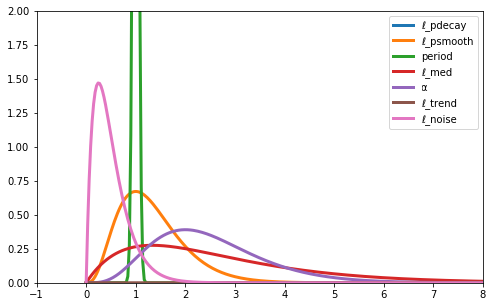

In [13]:
x = np.linspace(0, 150, 5000)

priors = [ ("ℓ_pdecay", pm.Gamma.dist(alpha=10, beta=0.075)),
            ("ℓ_psmooth", pm.Gamma.dist(alpha=4, beta=3)),
            ("period", pm.Normal.dist(mu=1.0, sigma=0.05)),
            ("ℓ_med", pm.Gamma.dist(alpha=2, beta=0.75)),
            ("α", pm.Gamma.dist(alpha=5, beta=2)),
            ("ℓ_trend", pm.Gamma.dist(alpha=4, beta=0.1)),
            ("ℓ_noise", pm.Gamma.dist(alpha=2, beta=4))
         ]
f, ax = pl.subplots(figsize=(8, 5))
for i, prior in enumerate(priors):
    ax.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0],
           lw=3)
ax.set_xlim(-1, 8)
ax.set_ylim(0, 2)
ax.legend();

We know beforehand which GP components should have a larger magnitude, so we include this information in the scale parameters.For all of the scale priors we use distributions that shrink the scale towards zero. The seasonal component and the long term trend have the least mass near zero, since they are the largest influences in the data.

* η_per: Scale of the periodic or seasonal component.
* η_med: Scale of the short to medium term component.
* η_trend: Scale of the long term trend.
* σ: Scale of the white noise.
* η_noise: Scale of correlated, short term noise.

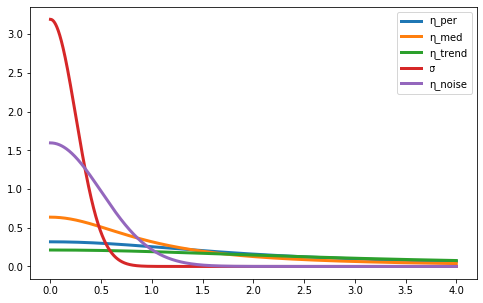

In [14]:
x = np.linspace(0, 4, 5000)
priors = [("η_per", pm.HalfCauchy.dist(beta=2)),
          ("η_med", pm.HalfCauchy.dist(beta=1.0)),
          ("η_trend", pm.HalfCauchy.dist(beta=3)),
          ("σ", pm.HalfNormal.dist(sigma=0.25)),
          ("η_noise", pm.HalfNormal.dist(sigma=0.5))
         ]
f, ax = pl.subplots(figsize=(8, 5))
for i, prior in enumerate(priors):
    ax.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0],
           lw=3)
#ax.set_xlim(-1, 8)
#ax.set_ylim(0, 2)
ax.legend();

### The model in PyMC3:
Each of the 3 component GPs is constructed separately

In [15]:
t = df_aosaaz_early.t.values[:, None]
y = df_aosaaz_early.yn.values

In [16]:
with pm.Model() as m1:
    # yearly periodic component
    η_per = pm.HalfCauchy("η_per", beta=2)
    ℓ_pdecay = pm.Gamma("ℓ_pdecay", alpha=10, beta=0.075)
    period = pm.Normal("period", mu=1, sigma=0.05)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth", alpha=4, beta=3)
    cov_seasonal = η_per **2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth)\
                        * pm.gp.cov.Matern52(1, ℓ_pdecay)
    gp_seasonal = pm.gp.Marginal(cov_func=cov_seasonal)
    
    #small/medium term irregularities
    η_med = pm.HalfCauchy("η_med", beta=0.5)
    ℓ_med = pm.Gamma("ℓ_med", alpha=2, beta=0.75)
    α = pm.Gamma("α", alpha=5, beta=2)
    cov_medium = η_med ** 2 * pm.gp.cov.RatQuad(1, ℓ_med, α)
    gp_medium = pm.gp.Marginal(cov_func=cov_medium)
    
    #long term trend
    η_trend = pm.HalfCauchy("η_trend", beta=2, )
    ℓ_trend = pm.Gamma("ℓ_trend", alpha=4, beta=0.1)
    cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
    gp_trend = pm.gp.Marginal(cov_func=cov_trend)
    
    #noise model
    η_noise = pm.HalfNormal("η_noise", sigma=0.5)
    ℓ_noise = pm.Gamma("ℓ_noise", alpha=2, beta=4)
    σ = pm.HalfNormal("σ", sigma=0.25,)
    cov_noise = η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) +\
                pm.gp.cov.WhiteNoise(σ)
    
    #GP model is based on sum of three components:
    gp = gp_seasonal + gp_medium + gp_trend
    y_ = gp.marginal_likelihood("y", X=t, y=y, noise=cov_noise)

/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [17]:
renderer = pm.model_to_graphviz(m1)
renderer.format = 'png'
renderer.render('gp_3_comp', directory='./')

'./gp_3_comp.png'

<img src='./gp_3_comp.png' height='500px' width='00px' >

In [43]:
with m1:
    mp = pm.find_MAP(include_transformed=True)

/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')

  0%|          | 0/5000 [00:00<?, ?it/s]
logp = -413.27, ||grad|| = 4,598.9:   0%|          | 0/5000 [00:00<?, ?it/s]
logp = -413.27, ||grad|| = 4,598.9:   0%|          | 1/5000 [00:00<12:26,  6.70it/s]
logp = -413.27, ||grad|| = 4,598.9:   0%|          | 3/5000 [00:00<11:12,  7.43it/s]
logp = -413.27, ||grad|| = 4,598.9:   0%|          | 4/5000 [00:00<14:12,  5.86it/s]
logp = -413.27, ||grad|| = 4,598.9:   0%|          | 5/5000 [00:00<13:51,  6.01it/s]
logp = -413.27, ||grad|| = 4,598.9:   0%|          | 6/5000 [00:00<14:29,  5.74it/s]
logp = -413.27, ||grad|| =

logp = -183.91, ||grad|| = 26.176:   2%|▏         | 86/5000 [00:15<15:09,  5.40it/s]
logp = -183.91, ||grad|| = 26.176:   2%|▏         | 87/5000 [00:15<15:19,  5.34it/s]
logp = -183.91, ||grad|| = 26.176:   2%|▏         | 88/5000 [00:15<13:20,  6.14it/s]
logp = -183.91, ||grad|| = 26.176:   2%|▏         | 89/5000 [00:15<15:58,  5.12it/s]
logp = -183.91, ||grad|| = 26.176:   2%|▏         | 90/5000 [00:15<14:20,  5.71it/s]
logp = -183.63, ||grad|| = 79.634:   2%|▏         | 90/5000 [00:16<14:20,  5.71it/s]
logp = -183.63, ||grad|| = 79.634:   2%|▏         | 91/5000 [00:16<14:27,  5.66it/s]
logp = -183.63, ||grad|| = 79.634:   2%|▏         | 92/5000 [00:16<13:39,  5.99it/s]
logp = -183.63, ||grad|| = 79.634:   2%|▏         | 93/5000 [00:16<13:15,  6.16it/s]
logp = -183.63, ||grad|| = 79.634:   2%|▏         | 94/5000 [00:16<13:54,  5.88it/s]
logp = -183.63, ||grad|| = 79.634:   2%|▏         | 95/5000 [00:16<13:06,  6.24it/s]
logp = -183.63, ||grad|| = 79.634:   2%|▏         | 96/5000 [00:1

logp = -183.43, ||grad|| = 0.59603:   4%|▎         | 176/5000 [00:30<14:08,  5.69it/s]
logp = -183.43, ||grad|| = 0.59603:   4%|▎         | 177/5000 [00:31<13:58,  5.75it/s]
logp = -183.43, ||grad|| = 0.59603:   4%|▎         | 179/5000 [00:31<12:33,  6.39it/s]
logp = -183.43, ||grad|| = 0.59603:   4%|▎         | 180/5000 [00:31<12:08,  6.62it/s]
logp = -183.43, ||grad|| = 0.67462:   4%|▎         | 180/5000 [00:31<12:08,  6.62it/s]
logp = -183.43, ||grad|| = 0.67462:   4%|▎         | 181/5000 [00:31<15:12,  5.28it/s]
logp = -183.43, ||grad|| = 0.67462:   4%|▎         | 182/5000 [00:31<14:10,  5.66it/s]
logp = -183.43, ||grad|| = 0.67462:   4%|▎         | 183/5000 [00:32<16:12,  4.95it/s]
logp = -183.43, ||grad|| = 0.67462:   4%|▎         | 184/5000 [00:32<13:55,  5.77it/s]
logp = -183.43, ||grad|| = 0.67462:   4%|▎         | 185/5000 [00:32<15:15,  5.26it/s]
logp = -183.43, ||grad|| = 0.67462:   4%|▎         | 187/5000 [00:32<12:22,  6.49it/s]
logp = -183.43, ||grad|| = 0.67462:   4%|▍ 